In [339]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn.metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
data = pd.read_csv('~/Desktop/project2/data.csv')
data.shape

(101766, 50)

In [340]:
#Remove "[", ")", ">", and "<"
data['age']=data['age'].str.replace('[','')
data['age']=data['age'].str.replace(')','')
data['weight']=data['weight'].str.replace('[','')
data['weight']=data['weight'].str.replace(')','')
data['max_glu_serum']=data['max_glu_serum'].str.replace('>','greater_than_')
data['A1Cresult']=data['A1Cresult'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('>','greater_than_')
data['readmitted']=data['readmitted'].str.replace('<','smaller_than_')


In [341]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,...,60-70,70-80,80-90,80-90,60-70,70-80,80-90,70-80,80-90,70-80
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6


# Missing Values
Want to drop medical_specialty,weight ,payer_code for sure

In [342]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [343]:

#Create new variable 'readmitted_yes' for binary classification
data['readmitted_yes']= (data['readmitted'] == 'greater_than_30').astype(int) +  (data['readmitted'] == 'smaller_than_30').astype(int) 

In [344]:
data.groupby(["readmitted_yes"])['readmitted_yes'].count()

readmitted_yes
0    54864
1    46902
Name: readmitted_yes, dtype: int64

In [345]:
# Encode change column, gender, diabetesMed column
# ch to Yes to 1, No to 1 
# gender: Male to 1, Female to 0
# DiabetesMed: Yed to 1, No to 0

In [346]:
data['change'] = data['change'].replace('Ch', 1)
data['change'] = data['change'].replace('No', 0)
data['gender'] = data['gender'].replace('Male', 1)
data['gender'] = data['gender'].replace('Female', 0)
data['diabetesMed'] = data['diabetesMed'].replace('Yes', 1)
data['diabetesMed'] = data['diabetesMed'].replace('No', 0)


In [347]:
# there are 24 features of medicine,which indicates whether the drug 
# was prescribed or there was a change in the dosage
# Possible values: “up” if the dosage was increased during the encounter, 
# “down” if the dosage was decreased, “steady” if the dosage did not change,
# and “no” if the drug was not prescribed

meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin',
        'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone',
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

In [348]:
# Encode Up to 3, steady to 2, down to 1, no to 0
for col in meds:
    data[col] = data[col].replace('No', 0)
    data[col] = data[col].replace('Steady', 2)
    data[col] = data[col].replace('Up', 3)
    data[col] = data[col].replace('Down', 1)

In [349]:
data.groupby(['age'])['age'].count()

age
0-10        161
10-20       691
20-30      1657
30-40      3775
40-50      9685
50-60     17256
60-70     22483
70-80     26068
80-90     17197
90-100     2793
Name: age, dtype: int64

In [350]:

# Convert age to numerical, take the mid point of each interval, 5,15,25, etc

data['age'] = data['age'].replace('0-10', 5)
data['age'] = data['age'].replace('10-20', 15)
data['age'] = data['age'].replace('20-30', 25)
data['age'] = data['age'].replace('30-40', 35)
data['age'] = data['age'].replace('40-50', 45)
data['age'] = data['age'].replace('50-60', 55)
data['age'] = data['age'].replace('60-70', 65)
data['age'] = data['age'].replace('70-80', 75)
data['age'] = data['age'].replace('80-90', 85)
data['age'] = data['age'].replace('90-100', 95)

In [351]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,0,1,1,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
age,5,15,25,35,45,55,65,75,85,95,...,65,75,85,85,65,75,85,75,85,75
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6


In [352]:
# convert examide and citoglipton to binary
data.groupby(['examide'])['examide'].count()
data.groupby(['citoglipton'])['citoglipton'].count()
# No need, all values are NO, just drop them

citoglipton
No    101766
Name: citoglipton, dtype: int64

In [353]:
# Drop payer_code, weight, medical_specialty, readmitted, examide, citoglipton
del_columns = ['weight', 'payer_code', 'medical_specialty','examide','citoglipton','readmitted']
data.drop(del_columns, inplace=True, axis=1)


In [354]:
del_col = ["encounter_id","patient_nbr"]
data.drop(del_col, inplace=True, axis=1)

In [355]:
df = data

In [356]:
# Recode diag1, diag2, diag3

df.loc[df['diag_1'].str.contains('V'), ['diag_1']] = "SUPPLEMENTARY"
df.loc[df['diag_2'].str.contains('V'), ['diag_2']] = "SUPPLEMENTARY"
df.loc[df['diag_3'].str.contains('V'), ['diag_3']] = "SUPPLEMENTARY"

df.loc[df['diag_1'].str.contains('E'), ['diag_1']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_2'].str.contains('E'), ['diag_2']] = "SUPPLEMENTARY_EXTERNAL"
df.loc[df['diag_3'].str.contains('E'), ['diag_3']] = "SUPPLEMENTARY_EXTERNAL"

df['diag_1'] = df['diag_1'].replace('?', "NONE")
df['diag_2'] = df['diag_2'].replace('?', "NONE")
df['diag_3'] = df['diag_3'].replace('?', "NONE")

In [357]:
#df['diag_1'] = pd.to_numeric(df['diag_1'], errors='ignore')
#df['diag_2']= pd.to_numeric(df['diag_2'], errors='ignore')
#df['diag_3']= pd.to_numeric(df['diag_3'], errors='ignore')

In [358]:
# Helper function to convert str to float
def change_to_num(col):
    res = []
    for i in col:
        if i not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
            res.append(float(i))
        else:
            res.append(i)
    return res
        

In [359]:
df['diag_1'] = change_to_num(df['diag_1'])
df['diag_2'] = change_to_num(df['diag_2'])
df['diag_3'] = change_to_num(df['diag_3'])

In [360]:
df['diag_1']

0                         250.83
1                            276
2                            648
3                              8
4                            197
5                            414
6                            414
7                            428
8                            398
9                            434
10                         250.7
11                           157
12                           428
13                           428
14                           518
15                           999
16                           410
17                           682
18                           402
19                           737
20                           410
21                           572
22                           410
23        SUPPLEMENTARY_EXTERNAL
24                           189
25                           786
26                           427
27                           996
28                           277
29                           428
          

In [361]:
new_diag_1

['ENDO_NUTRI_METABOLIC',
 'ENDO_NUTRI_METABOLIC',
 'PREGNANCY',
 'INFECTIOUS_PARASTIC_DISEASE',
 'NEOPLASMS',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'ENDO_NUTRI_METABOLIC',
 'NEOPLASMS',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'RESPIRATORY_SYSTEM_DISEASE',
 'INJURY_POISONING',
 'CIRCULATORY_SYSTEM_DISEASE',
 'SKIN_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'MUSCULOSKELETAL_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'DIGESTIVE_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'SUPPLEMENTARY_EXTERNAL',
 'NEOPLASMS',
 'ILL_DEFINED_COND',
 'CIRCULATORY_SYSTEM_DISEASE',
 'INJURY_POISONING',
 'ENDO_NUTRI_METABOLIC',
 'CIRCULATORY_SYSTEM_DISEASE',
 'GENETOURINARY_SYSTEM_DISEASE',
 'RESPIRATORY_SYSTEM_DISEASE',
 'INJURY_POISONING',
 'RESPIRATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'CIRCULATORY_SYSTEM_DISEASE',
 'NEOPLASMS',
 'RESPIRATORY_S

In [362]:
new_diag_1 = []
for index, row in df.iterrows():
    if row['diag_1'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_1'] >= 1 and row['diag_1'] <= 139):
            new_diag_1.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_1'] >= 140 and row['diag_1'] <= 239):
            new_diag_1.append("NEOPLASMS")
        elif (row['diag_1'] >= 240 and row['diag_1'] <= 279):
            new_diag_1.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_1'] >= 280 and row['diag_1'] <= 289):
            new_diag_1.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_1'] >= 290 and row['diag_1'] <= 319):
            new_diag_1.append("MENTAL_DISORDER")
        elif (row['diag_1'] >= 320 and row['diag_1'] <= 389):
            new_diag_1.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_1'] >= 390 and row['diag_1'] <= 459):
            new_diag_1.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 460 and row['diag_1'] <= 519):
            new_diag_1.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 520 and row['diag_1'] <= 579):
            new_diag_1.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 580 and row['diag_1'] <= 629):
            new_diag_1.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 630 and row['diag_1'] <= 679):
            new_diag_1.append("PREGNANCY")
        elif (row['diag_1'] >= 680 and row['diag_1'] <= 709):
            new_diag_1.append("SKIN_DISEASE")
        elif (row['diag_1'] >= 710 and row['diag_1'] <= 739):
            new_diag_1.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_1'] >= 740 and row['diag_1'] <= 759):
            new_diag_1.append("CONGENITAL_ANOMALIES")
        elif (row['diag_1'] >= 760 and row['diag_1'] <= 779):
            new_diag_1.append("PERINATAL_PERIOD")
        elif (row['diag_1'] >= 780 and row['diag_1'] <= 799):
            new_diag_1.append("ILL_DEFINED_COND")
        elif (row['diag_1'] >= 800 and row['diag_1'] <= 999):
            new_diag_1.append("INJURY_POISONING")
    else:
        new_diag_1.append(row['diag_1'])


In [363]:
df['diag_1'] = pd.Series(new_diag_1)

In [364]:
new_diag_2 = []
for index, row in df.iterrows():
    if row['diag_2'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_2'] >= 1 and row['diag_2'] <= 139):
            new_diag_2.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_2'] >= 140 and row['diag_2'] <= 239):
            new_diag_2.append("NEOPLASMS")
        elif (row['diag_2'] >= 240 and row['diag_2'] <= 279):
            new_diag_2.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_2'] >= 280 and row['diag_2'] <= 289):
            new_diag_2.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_2'] >= 290 and row['diag_2'] <= 319):
            new_diag_2.append("MENTAL_DISORDER")
        elif (row['diag_2'] >= 320 and row['diag_2'] <= 389):
            new_diag_2.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_2'] >= 390 and row['diag_2'] <= 459):
            new_diag_2.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 460 and row['diag_2'] <= 519):
            new_diag_2.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 520 and row['diag_2'] <= 579):
            new_diag_2.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 580 and row['diag_2'] <= 629):
            new_diag_2.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 630 and row['diag_2'] <= 679):
            new_diag_2.append("PREGNANCY")
        elif (row['diag_2'] >= 680 and row['diag_2'] <= 709):
            new_diag_2.append("SKIN_DISEASE")
        elif (row['diag_2'] >= 710 and row['diag_2'] <= 739):
            new_diag_2.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_2'] >= 740 and row['diag_2'] <= 759):
            new_diag_2.append("CONGENITAL_ANOMALIES")
        elif (row['diag_2'] >= 760 and row['diag_2'] <= 779):
            new_diag_2.append("PERINATAL_PERIOD")
        elif (row['diag_2'] >= 780 and row['diag_2'] <= 799):
            new_diag_2.append("ILL_DEFINED_COND")
        elif (row['diag_2'] >= 800 and row['diag_2'] <= 999):
            new_diag_2.append("INJURY_POISONING")
    else:
        new_diag_2.append(row['diag_2'])

df['diag_2'] = pd.Series(new_diag_2)

In [365]:
new_diag_3 = []
for index, row in df.iterrows():
    if row['diag_3'] not in {"NONE","SUPPLEMENTARY_EXTERNAL","SUPPLEMENTARY"}:
        if (row['diag_3'] >= 1 and row['diag_3'] <= 139):
            new_diag_3.append("INFECTIOUS_PARASTIC_DISEASE")
        elif (row['diag_3'] >= 140 and row['diag_3'] <= 239):
            new_diag_3.append("NEOPLASMS")
        elif (row['diag_3'] >= 240 and row['diag_3'] <= 279):
            new_diag_3.append("ENDO_NUTRI_METABOLIC")
        elif (row['diag_3'] >= 280 and row['diag_3'] <= 289):
            new_diag_3.append("BLOOD_ORGANS_DISEASE")
        elif (row['diag_3'] >= 290 and row['diag_3'] <= 319):
            new_diag_3.append("MENTAL_DISORDER")
        elif (row['diag_3'] >= 320 and row['diag_3'] <= 389):
            new_diag_3.append("NERVOUS_SENSE_DISEASE")
        elif (row['diag_3'] >= 390 and row['diag_3'] <= 459):
            new_diag_3.append("CIRCULATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 460 and row['diag_3'] <= 519):
            new_diag_3.append("RESPIRATORY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 520 and row['diag_3'] <= 579):
            new_diag_3.append("DIGESTIVE_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 580 and row['diag_3'] <= 629):
            new_diag_3.append("GENETOURINARY_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 630 and row['diag_3'] <= 679):
            new_diag_3.append("PREGNANCY")
        elif (row['diag_3'] >= 680 and row['diag_3'] <= 709):
            new_diag_3.append("SKIN_DISEASE")
        elif (row['diag_3'] >= 710 and row['diag_3'] <= 739):
            new_diag_3.append("MUSCULOSKELETAL_SYSTEM_DISEASE")
        elif (row['diag_3'] >= 740 and row['diag_3'] <= 759):
            new_diag_3.append("CONGENITAL_ANOMALIES")
        elif (row['diag_3'] >= 760 and row['diag_3'] <= 779):
            new_diag_3.append("PERINATAL_PERIOD")
        elif (row['diag_3'] >= 780 and row['diag_3'] <= 799):
            new_diag_3.append("ILL_DEFINED_COND")
        elif (row['diag_3'] >= 800 and row['diag_3'] <= 999):
            new_diag_3.append("INJURY_POISONING")
    else:
        new_diag_3.append(row['diag_3'])

df['diag_3'] = pd.Series(new_diag_3)

In [257]:
df.to_csv("~/Desktop/recode_data.csv",index=False)

In [285]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,0,1,1,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
age,5,15,25,35,45,55,65,75,85,95,...,65,75,85,85,65,75,85,75,85,75
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,46,21,76,1,45,51,33,53,45,13
num_procedures,0,0,5,1,0,6,1,0,2,3,...,6,1,1,0,1,0,3,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18,...,17,16,22,15,25,16,18,9,21,3


In [366]:
df.groupby(['gender'])['gender'].count()

gender
0                  54708
1                  47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [367]:
df.drop(df[df.gender == "Unknown/Invalid"].index, inplace=True)

In [368]:
df.groupby(['gender'])['gender'].count()

gender
0    54708
1    47055
Name: gender, dtype: int64

In [369]:
df_2 = pd.get_dummies(df, columns=['diag_1','diag_2','diag_3','max_glu_serum',
                                   'A1Cresult','race',
                                   'admission_type_id',
                                   'discharge_disposition_id','admission_source_id'], drop_first=True)

In [302]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [303]:
#Construct predicted variable 'readmitted_yes' and predictors
Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_yes',axis=1)
seed = 7
test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [304]:
df_2.T

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
gender,0,0,0,1,1,1,1,1,0,0,...,0,0,0,1,0,1,0,1,0,1
age,5,15,25,35,45,55,65,75,85,95,...,65,75,85,85,65,75,85,75,85,75
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,46,21,76,1,45,51,33,53,45,13
num_procedures,0,0,5,1,0,6,1,0,2,3,...,6,1,1,0,1,0,3,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18,...,17,16,22,15,25,16,18,9,21,3
number_outpatient,0,0,2,0,0,0,0,0,0,0,...,1,0,0,3,3,0,0,1,0,0


In [305]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [310]:
lr.score(X_test,Y_test)

0.6251861116074088

In [306]:
Y_pred = lr.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[14356,  3714],
       [ 8873,  6639]])

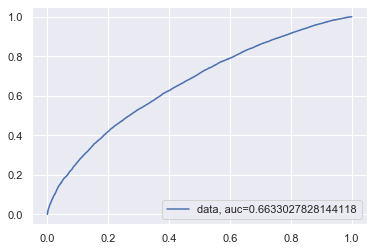

In [313]:
from sklearn import metrics
y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [334]:
from sklearn.tree import DecisionTreeClassifier
max_depth = [2,4,6,8,10,12,14,16,18,20,25,30,35,40,45]
gini_score = []
entropy_score = []
for d in max_depth:
    clf_gini = DecisionTreeClassifier(max_depth = d)
    clf_gini = clf_gini.fit(X_train, Y_train)
    gini_score.append(clf_gini.score(X_test,Y_test))
    clf_ig = DecisionTreeClassifier(max_depth = d,criterion = "entropy")
    clf_ig = clf_ig.fit(X_train,Y_train)
    entropy_score.append(clf_ig.score(X_test,Y_test))
gini_score,entropy_score

([0.6147638615925198,
  0.6275981180394259,
  0.6300994580429993,
  0.6299207908998868,
  0.627985230182836,
  0.6197069858852957,
  0.6099100708713001,
  0.6033291644333274,
  0.5923411351319159,
  0.5881424572687749,
  0.5712584122446549,
  0.5708117443868739,
  0.5657495086653564,
  0.5639628372342326,
  0.5644095050920136],
 [0.6147638615925198,
  0.6275981180394259,
  0.6311119051873028,
  0.6299505687570722,
  0.6267345601810493,
  0.6227741051753916,
  0.6139598594485141,
  0.6055625037222322,
  0.5948722529926747,
  0.5920135787028765,
  0.5763504258233577,
  0.570365076529093,
  0.5683104043833006,
  0.567446846524924,
  0.5680721815258174])

In [335]:
from sklearn import tree
clf_ig = DecisionTreeClassifier(max_depth = 6)
clf_ig = clf_ig.fit(X_train, Y_train)


In [336]:
pred_list = clf_ig.predict(X_train)
metrics.accuracy_score(pred_list,Y_train)

0.6316862469016294

In [337]:
test_pred = clf_ig.predict(X_test)
metrics.accuracy_score(test_pred,Y_test)

0.6299803466142576

[Text(329.22, 757.1571428571428, 'number_inpatient <= 0.5\nentropy = 0.497\nsamples = 68181\nvalue = [36791, 31390]\nclass = y[0]'),
 Text(161.1225, 640.6714285714286, 'number_diagnoses <= 5.5\nentropy = 0.474\nsamples = 45340\nvalue = [27883, 17457]\nclass = y[0]'),
 Text(76.725, 524.1857142857143, 'age <= 60.0\nentropy = 0.415\nsamples = 10742\nvalue = [7586, 3156]\nclass = y[0]'),
 Text(41.85, 407.7, 'number_emergency <= 0.5\nentropy = 0.377\nsamples = 5048\nvalue = [3775, 1273]\nclass = y[0]'),
 Text(22.32, 291.21428571428567, 'discharge_disposition_id <= 1.5\nentropy = 0.369\nsamples = 4773\nvalue = [3607, 1166]\nclass = y[0]'),
 Text(11.16, 174.7285714285714, 'time_in_hospital <= 5.5\nentropy = 0.355\nsamples = 3970\nvalue = [3053, 917]\nclass = y[0]'),
 Text(5.58, 58.24285714285713, 'entropy = 0.344\nsamples = 3551\nvalue = [2766, 785]\nclass = y[0]'),
 Text(16.740000000000002, 58.24285714285713, 'entropy = 0.432\nsamples = 419\nvalue = [287, 132]\nclass = y[0]'),
 Text(33.48000

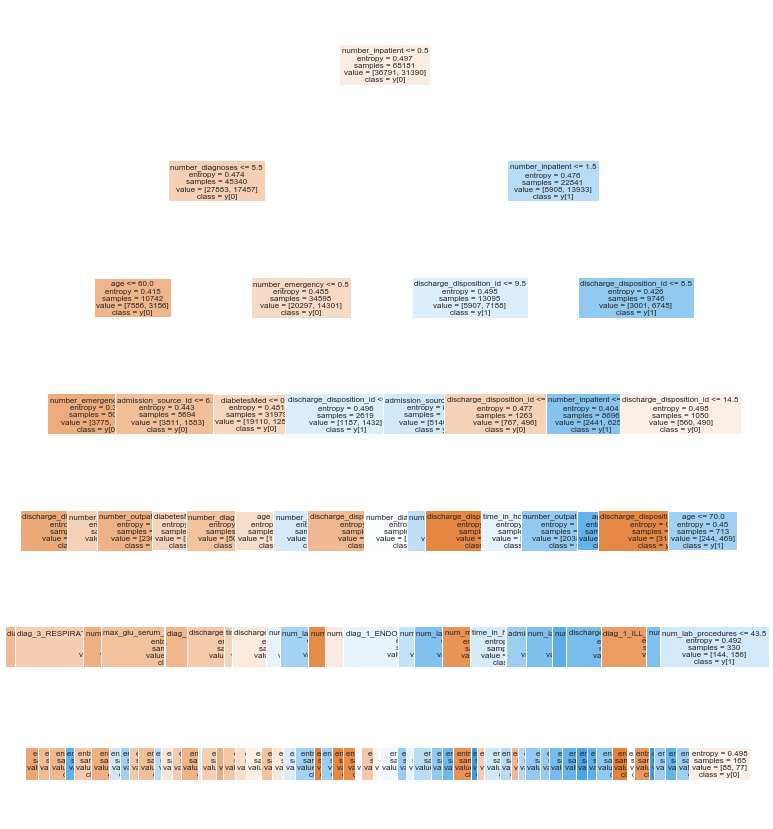

In [338]:
fig, ax = plt.subplots(figsize=(12,15))
tree.plot_tree(clf_ig,max_depth = 6, filled = True,fontsize = 8,feature_names = X_train.columns, class_names = True,ax=ax)


Text(0.5, 1.0, 'Age VS. Readmission')

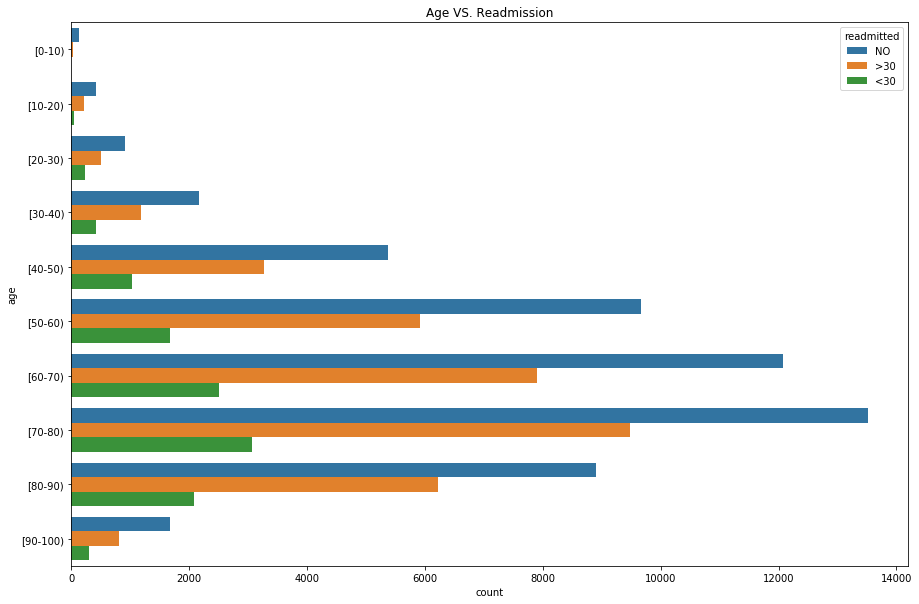

In [6]:
import seaborn as sns
fig = plt.figure(figsize=(15,10))
sns.countplot(y= data['age'], hue = data['readmitted']).set_title('Age VS. Readmission')

Text(0.5, 1.0, 'Discharge Dosposition VS. Readmission')

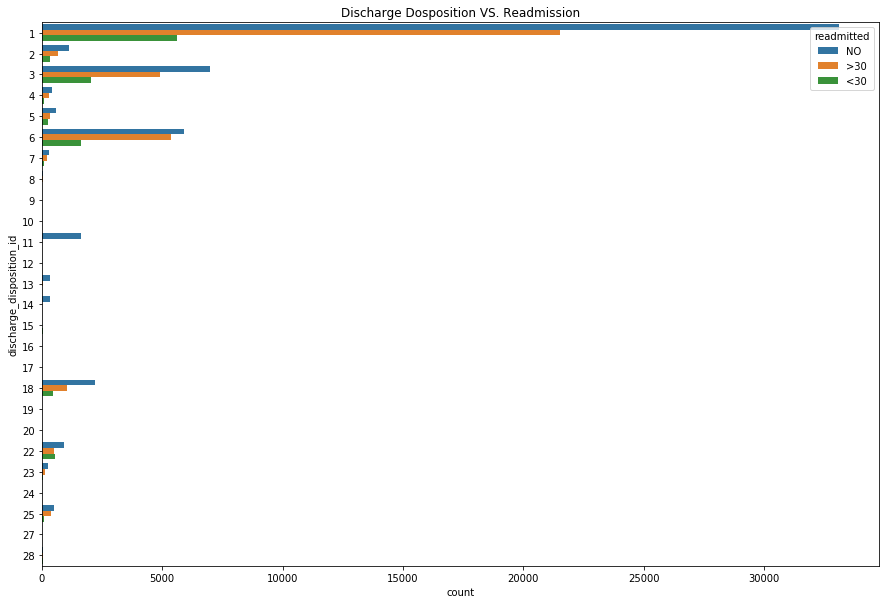

In [7]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= data['discharge_disposition_id'], hue = data['readmitted']).set_title('Discharge Dosposition VS. Readmission')

Text(0.5, 1.0, 'Gender VS. Readmission')

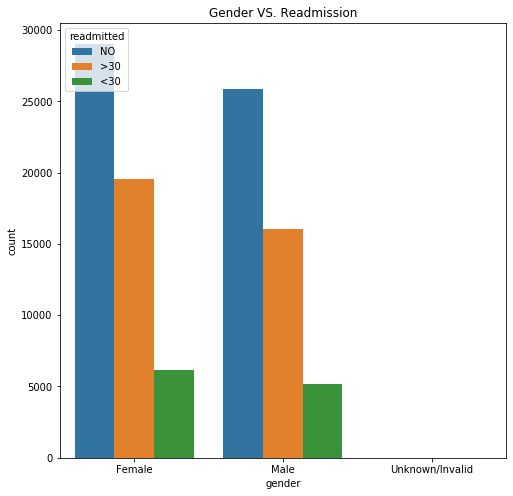

In [8]:
fig = plt.figure(figsize=(8,8))
sns.countplot(data['gender'], hue = data['readmitted']).set_title('Gender VS. Readmission')

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

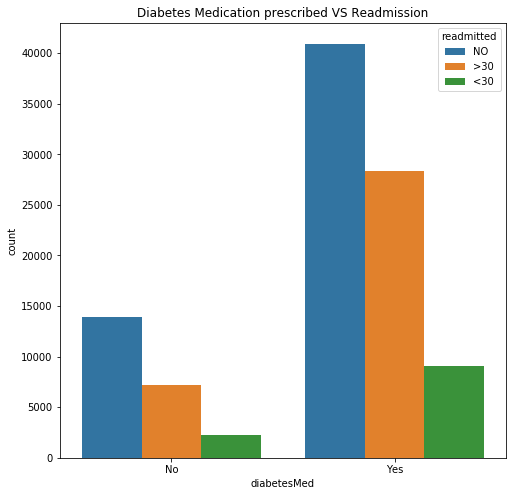

In [9]:
fig = plt.figure(figsize=(8,8))
sns.countplot(data['diabetesMed'], hue = data['readmitted']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Admission Source VS Readmission')

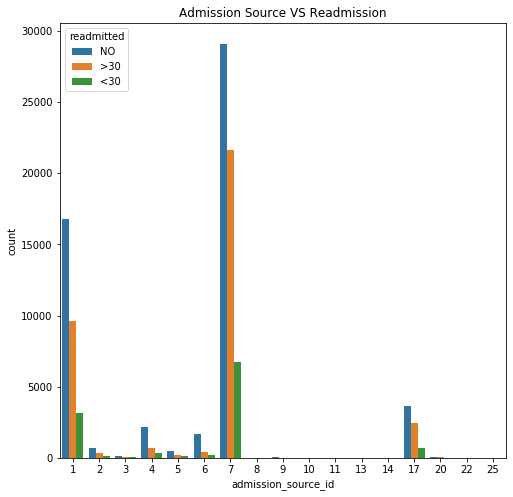

In [10]:
fig = plt.figure(figsize=(8,8))
sns.countplot(data['admission_source_id'], hue = data['readmitted']).set_title('Admission Source VS Readmission')

Text(0.5, 1.0, 'Inpatient VS. Readmission')

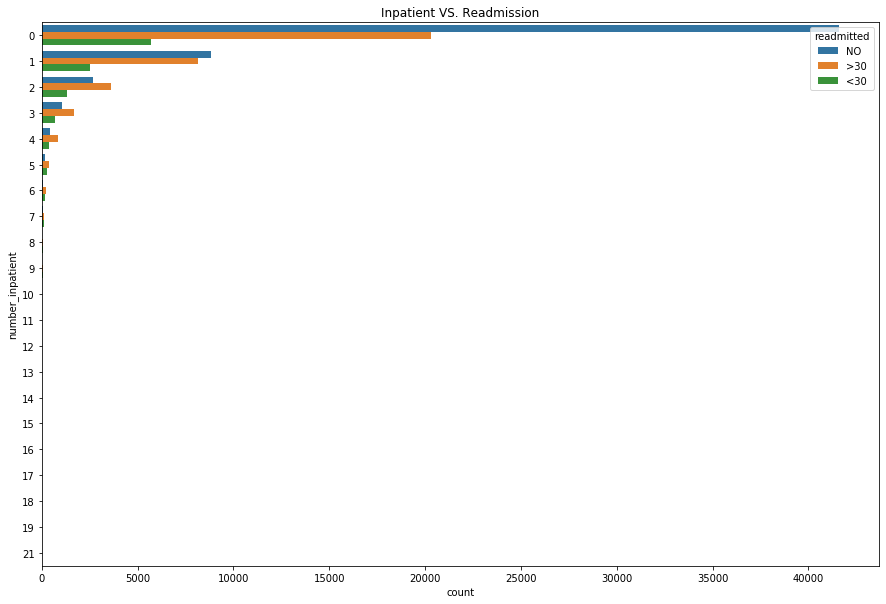

In [11]:
fig = plt.figure(figsize=(15,10))
sns.countplot(y= data['number_inpatient'], hue = data['readmitted']).set_title('Inpatient VS. Readmission')

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,...,443842070,443842136,443842340,443842778,443847176,443847548,443847782,443854148,443857166,443867222
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,...,140199494,181593374,120975314,86472243,50375628,100162476,74694222,41088789,31693671,175429310
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,...,60-70,70-80,80-90,80-90,60-70,70-80,80-90,70-80,80-90,70-80
weight,?,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3,...,1,1,1,1,1,1,1,1,2,1
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,...,1,1,1,1,1,3,4,1,3,1
admission_source_id,1,7,7,7,7,2,2,7,4,4,...,7,7,7,7,7,7,5,7,7,7
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6


# Missing Values


In [14]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [15]:
#Change categorical variables to one-hot vectors
df_2 = pd.get_dummies(data, columns=['race', 'gender','age','admission_type_id','discharge_disposition_id',
                                     'admission_source_id','payer_code','medical_specialty','diag_1','diag_2','diag_3',
                                     'max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide',
                                     'glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
                                     'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton',
                                     'insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
                                     'metformin-rosiglitazone',
                                     'metformin-pioglitazone','change','diabetesMed','readmitted'], drop_first=True)
#Create new variable 'readmitted_yes' for binary classification
df_2['readmitted_yes']=df_2['readmitted_greater_than_30']+df_2['readmitted_smaller_than_30']

In [16]:
df_2.head()

,encounter_id,patient_nbr,weight,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,readmitted_greater_than_30,readmitted_smaller_than_30,readmitted_yes
0,2278392,8222157,?,1,41,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,149190,55629189,?,3,59,0,18,0,0,0,...,0,0,0,0,0,0,1,1,0,1
2,64410,86047875,?,2,11,5,13,2,0,1,...,0,0,0,0,0,1,1,0,0,0
3,500364,82442376,?,2,44,1,16,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,16680,42519267,?,1,51,0,8,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
#Construct predicted variable 'readmitted_yes' and predictors
Y=df_2['readmitted_yes']
X=df_2.drop('readmitted_yes',axis=1)
X=X.drop('readmitted_greater_than_30',axis=1)
X=X.drop('readmitted_smaller_than_30',axis=1)
X=X.drop('weight',axis=1)
X=X.drop('encounter_id',axis=1)
X=X.drop('patient_nbr',axis=1)

In [18]:
#Train test split
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [20]:
from sklearn.tree import DecisionTreeClassifier
max_depth = [2,5,8,10,15]
gini_score = []
entropy_score = []
for d in max_depth:
    clf_gini = DecisionTreeClassifier(max_depth = d)
    clf_gini = clf_gini.fit(X_train, y_train)
    gini_score.append(clf_gini.score(X_train,y_train))
    clf_ig = DecisionTreeClassifier(max_depth = d,criterion = "entropy")
    clf_ig = clf_ig.fit(X_train,y_train)
    entropy_score.append(clf_ig.score(X_train,y_train))
gini_score,entropy_score

([0.620535910710881,
  0.6293357581801915,
  0.6392062537582682,
  0.6477421058034994,
  0.6846867987621548],
 [0.620535910710881,
  0.6284557734332605,
  0.6372409544901222,
  0.6441488347535309,
  0.6687444084302538])

In [21]:
X_train.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_AfricanAmerican',
       'race_Asian',
       ...
       'insulin_Up', 'glyburide-metformin_No', 'glyburide-metformin_Steady',
       'glyburide-metformin_Up', 'glipizide-metformin_Steady',
       'glimepiride-pioglitazone_Steady', 'metformin-rosiglitazone_Steady',
       'metformin-pioglitazone_Steady', 'change_No', 'diabetesMed_Yes'],
      dtype='object', length=2470)

In [22]:
from sklearn import tree
clf_ig = DecisionTreeClassifier(max_depth = 15)
clf_ig = clf_ig.fit(X_train, y_train)
# plot the tree


[Text(391.29750000000007, 757.1571428571428, 'number_inpatient <= 0.5\nentropy = 0.497\nsamples = 68183\nvalue = [36809, 31374]\nclass = y[0]'),
 Text(238.54500000000002, 640.6714285714286, 'number_diagnoses <= 6.5\nentropy = 0.473\nsamples = 45303\nvalue = [27874, 17429]\nclass = y[0]'),
 Text(133.92000000000002, 524.1857142857143, 'diag_1_428 <= 0.5\nentropy = 0.433\nsamples = 15491\nvalue = [10583, 4908]\nclass = y[0]'),
 Text(66.96000000000001, 407.7, 'number_emergency <= 0.5\nentropy = 0.428\nsamples = 14979\nvalue = [10329, 4650]\nclass = y[0]'),
 Text(33.480000000000004, 291.21428571428567, 'admission_type_id_6 <= 0.5\nentropy = 0.422\nsamples = 14266\nvalue = [9946, 4320]\nclass = y[0]'),
 Text(16.740000000000002, 174.7285714285714, 'diabetesMed_Yes <= 0.5\nentropy = 0.414\nsamples = 13189\nvalue = [9330, 3859]\nclass = y[0]'),
 Text(8.370000000000001, 58.24285714285713, '\n  (...)  \n'),
 Text(25.110000000000003, 58.24285714285713, '\n  (...)  \n'),
 Text(50.220000000000006, 1

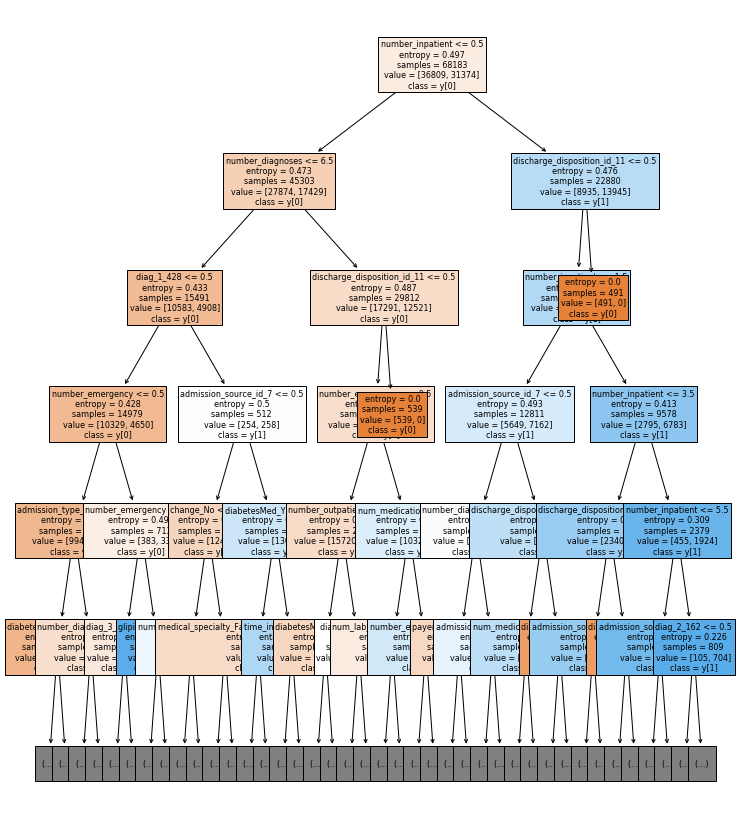

In [34]:

fig, ax = plt.subplots(figsize=(12,15))
tree.plot_tree(clf_ig,max_depth = 5, filled = True,fontsize = 8,feature_names = X_train.columns, class_names = True,ax=ax)


In [23]:
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 64.07%


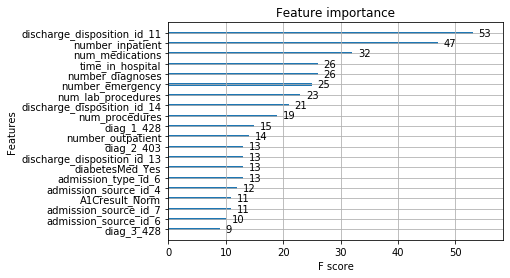

In [25]:
#importance plot
xgb.plot_importance(model, max_num_features=20)

In [11]:
data.groupby("readmitted")["readmitted"].describe().reset_index()

,readmitted,count,unique,top,freq
0,<30,11357,1,<30,11357
1,>30,35545,1,>30,35545
2,NO,54864,1,NO,54864


In [14]:
data.groupby("race")["race"].describe().reset_index()

,race,count,unique,top,freq
0,?,2273,1,?,2273
1,AfricanAmerican,19210,1,AfricanAmerican,19210
2,Asian,641,1,Asian,641
3,Caucasian,76099,1,Caucasian,76099
4,Hispanic,2037,1,Hispanic,2037
5,Other,1506,1,Other,1506


In [15]:
data.groupby("gender")["gender"].describe().reset_index()

,gender,count,unique,top,freq
0,Female,54708,1,Female,54708
1,Male,47055,1,Male,47055
2,Unknown/Invalid,3,1,Unknown/Invalid,3


In [16]:
data.groupby("age")["age"].describe().reset_index()

,age,count,unique,top,freq
0,[0-10),161,1,[0-10),161
1,[10-20),691,1,[10-20),691
2,[20-30),1657,1,[20-30),1657
3,[30-40),3775,1,[30-40),3775
4,[40-50),9685,1,[40-50),9685
5,[50-60),17256,1,[50-60),17256
6,[60-70),22483,1,[60-70),22483
7,[70-80),26068,1,[70-80),26068
8,[80-90),17197,1,[80-90),17197
9,[90-100),2793,1,[90-100),2793


In [18]:
data.groupby("weight")["weight"].describe().reset_index()#majority missing

,weight,count,unique,top,freq
0,>200,3,1,>200,3
1,?,98569,1,?,98569
2,[0-25),48,1,[0-25),48
3,[100-125),625,1,[100-125),625
4,[125-150),145,1,[125-150),145
5,[150-175),35,1,[150-175),35
6,[175-200),11,1,[175-200),11
7,[25-50),97,1,[25-50),97
8,[50-75),897,1,[50-75),897
9,[75-100),1336,1,[75-100),1336


In [ ]:
#tried multiclass xgboost
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4))

# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)

clf.fit(X_train, y_train)